Import the following packages:

In [30]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
%matplotlib inline

### Regularization

Recall our $f(x)=\sin(2 \pi x)$ function from yesterday:

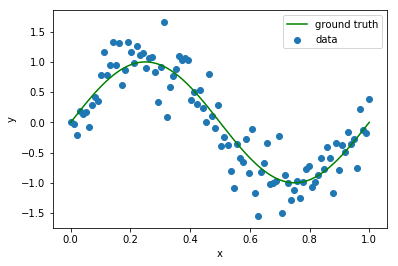

In [31]:
# We start by seeding the random number generator so that everyone will have the same "random" results
np.random.seed(9)

# Function that returns the sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)

# This returns 100 evenly spaced numbers from 0 to 1
X_plot = np.linspace(0, 1, 100)

#applying model.predict(X) needs the X to be a matrix so the line below adds another dimension
X = X_plot[:, np.newaxis]

# Generate the y values by taking the sin and adding a random Gaussian (normal) noise term
y = f(X_plot) + np.random.normal(0,.3,100)

# Plot the training data against what we know to be the ground truth sin function
fig,ax = plt.subplots(1,1)
ax.plot(X_plot, f(X_plot), label='ground truth', color='green')
ax.scatter(X_plot, y, label='data')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()


We fit various polynomials to the data:

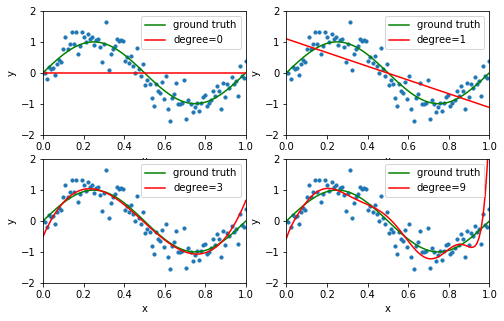

In [32]:
#helper function to plot things
def plot_approximation(model, ax, x_plot, y, label=None):
    """Plot the approximation of ``model`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), 'g', label="ground truth")
    ax.scatter(x_plot, y, s=10)
    x = x_plot[:, np.newaxis]
    ax.plot(x_plot, model.predict(x), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')

#split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.7)

#set up four subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

#fit different polynomials and plot approximations
for ax, degree in zip(axes.ravel(), [0, 1, 3, 9]):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    plot_approximation(model, ax, X_plot, y, label='degree=%d' % degree)

And we concluded that a polynomial between degree 3 and 6 would minimize the error:

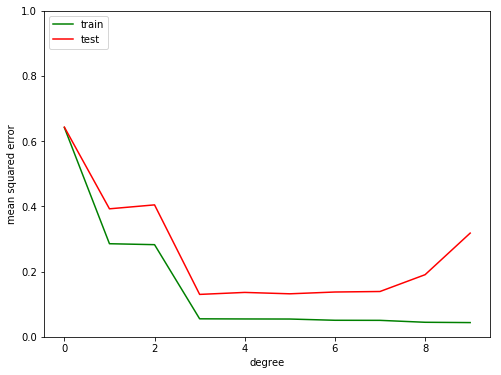

In [33]:
degrees = 10

train_error = []
test_error = []

for degree in range(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    train_error.append(mean_squared_error(y_train, model.predict(X_train)))
    test_error.append(mean_squared_error(y_test, model.predict(X_test)))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(degrees), train_error, color='green', label='train')
plt.plot(np.arange(degrees), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')

### Ridge Regression

#### Hand picking polynomials is hard work, and data scientists are lazy so....
...we would like a method that eliminates the need to manually select the degree of the polynomial: we can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. This constraint is called the **regularization** term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero. In the context of polynomial regression, constraining the magnitude of the regression coefficients effectively is a smoothness assumption: by constraining the L2 norm of the regression coefficients we express our preference for smooth functions rather than wiggly functions.

Don't let "L2 norm" scare you...It is just the distance formula that you know and love: $|(x_1,x_2,...x_n)|_2 = \sqrt{x_1^2+x_2^2+...+x_n^2}$.

A popular regularized linear regression model is **Ridge Regression**. This adds the L2 norm of the coefficients to the ordinary least squares objective:

  $J(\boldsymbol\theta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\theta^T \mathbf{x}_i')^2 + \alpha \|\boldsymbol\theta\|_2$

where $\boldsymbol\theta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i'$ is the i-th feature vector including a dummy feature for the intercept. The L2 norm term is weighted by a regularization parameter ``alpha``: if ``alpha=0`` then you recover the Ordinary Least Squares regression model. The larger the value of ``alpha`` the higher the smoothness constraint.

More specifically, if we are trying to come up with optimal parameters for the regression equation $f(x_1,x_2,...)=\theta_0+\theta_1 x_1 + \theta_2 x_1^2 + \theta_3 x_1 x_2 +\theta_4 x_2 ^2 ...$, then Ridge Regression minimizes our cost function   $J(\boldsymbol\theta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\theta^T \mathbf{x}_i')^2 + \alpha \sqrt{\theta_0^2+\theta_1^2+\theta_2^2...+\theta_n^2}=\frac{1}{n}\sum_{i=0}^n (y_i - (\theta_0+\theta_1 x_1 + \theta_2 x_1^2 + \theta_3 x_1 x_2 +\theta_4 x_2 ^2 ...))^2 + \alpha \sqrt{\theta_0^2+\theta_1^2+\theta_2^2...+\theta_n^2}$

Below you can see the approximation of a [``sklearn.linear_model.Ridge``](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) estimator fitting a polynomial of degree nine for various values of ``alpha`` (left) and the corresponding coefficient loadings (right). The smaller the value of ``alpha`` the higher the magnitude of the coefficients, so the functions we can model can be more and more wiggly. First, read in some helper functions:

In [34]:
# Bringing in our helper functions

def f(x):
    return np.sin(2 * np.pi * x)

x_plot = np.linspace(0, 1, 100)

#plots the left hand column plots below

def plot_approximation(model, ax, label=None):
    """Plot the approximation of ``model`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, model.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

# A helper function to plot the absolute value of the coefficients on the right-hand column plot
def plot_coefficients(model, ax, label=None):
    coef = model.steps[-1][1].coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label=label)
    ax.set_ylim((1e-1, 1e8))
    ax.set_xlim((1, 9))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')

Trying out 4 different values of the RidgeRegression parameter alpha, we see how the resulting models change.
With higher values of alpha, more complex (more wiggly) models will be more punished and thus less likely to score highly. We also notice in this case that alpha = 1e-05 has the highest $R^2$ score:

alpha:  0.0     R^2: 0.5048513991972219
alpha:  1e-05     R^2: 0.7989419726360503
alpha:  0.1     R^2: 0.6372330256140104
alpha:  1     R^2: 0.5081199085581771


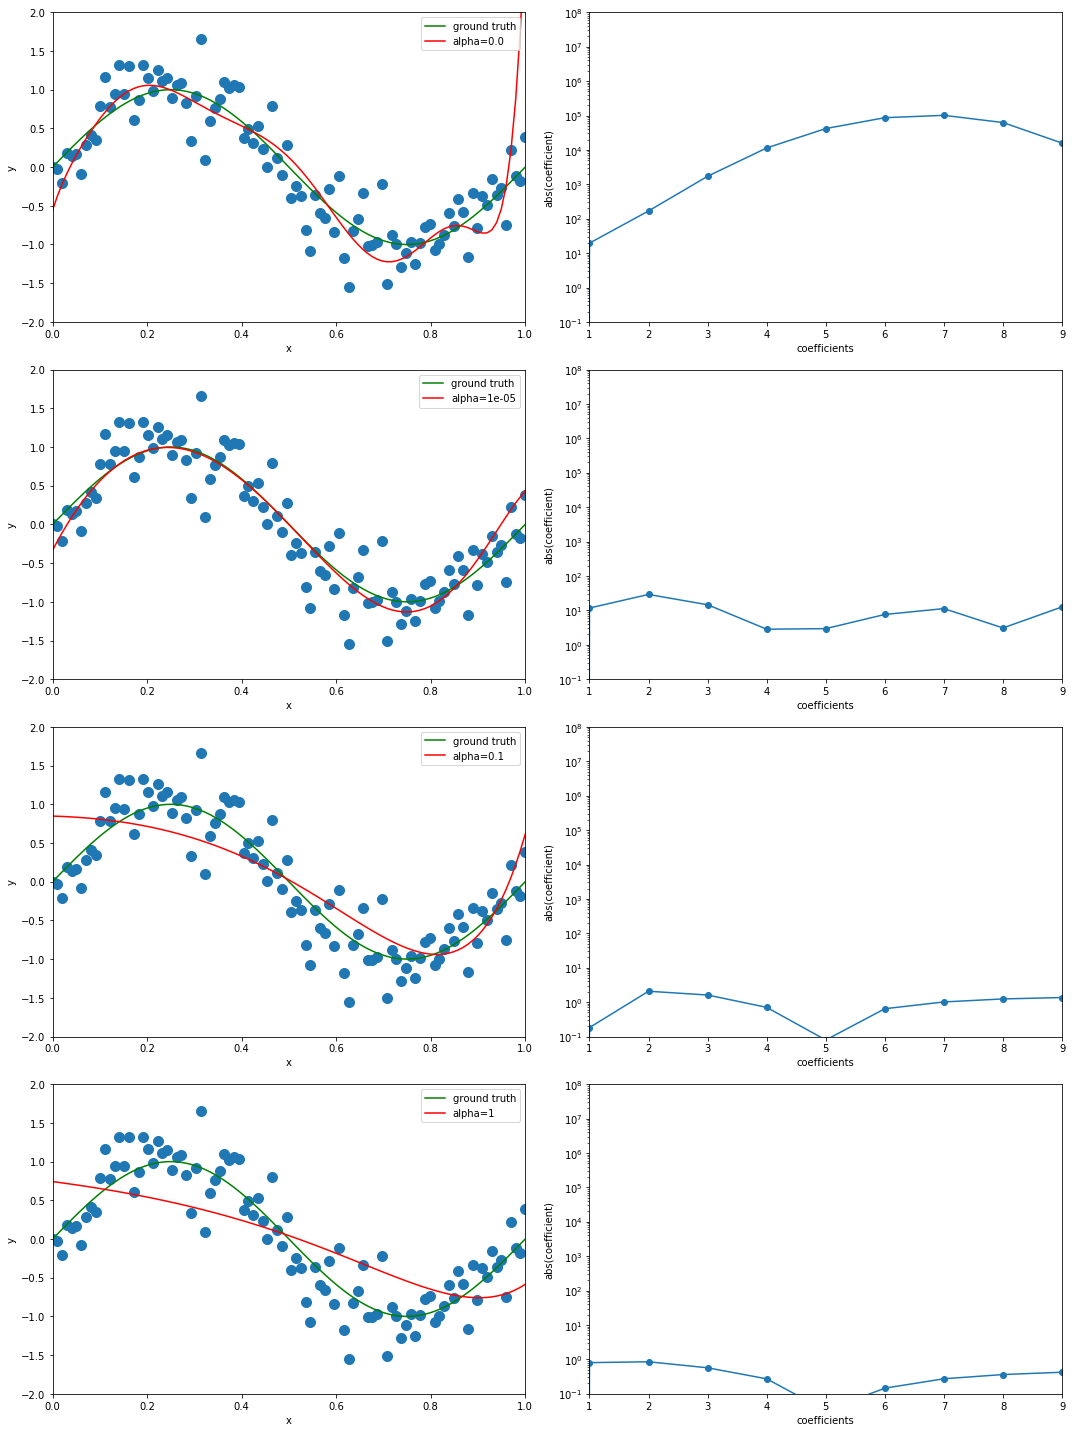

In [29]:
import warnings
warnings.filterwarnings("ignore")

# Set up a figure and axes for 8 plots, 2 per row for 4 rows
fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

degree = 9
alphas = [0.0, 1e-5, 1e-1, 1]

for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model.fit(X_train, y_train)
    
    print("alpha: ", alpha, "    R^2:", model.score(X_test, y_test))
    plot_approximation(model, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(model, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

Notice in the last model corresponding to alpha=1, we can acquire our intercept and coefficients from the pipeline:

In [27]:
print(model.steps[1][1].intercept_)
print(model.steps[1][1].coef_)

0.7416613325491779
[ 0.         -0.805065   -0.85323434 -0.57000594 -0.27233909 -0.03230409
  0.14592968  0.27349385  0.36267917  0.42363743]


What does mean that our model was? We will ignore the first coefficient (0) because it is actually contained in the separate intercept_ parameter. Thus:

$y_{\text{predicted}} = 0.74166 + -0.805065 x + -0.85323434 x^2 + ... + 0.42363743 x^9$

How does this model compare to the first picture in which alpha was 0? The coefficients were wayyyy bigger:

In [28]:
alpha = 0.0
model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
model.fit(X_train, y_train)
print(model.steps[1][1].intercept_)
print(model.steps[1][1].coef_)

-0.5565420393217826
[ 0.00000000e+00  1.94573477e+01 -1.67820001e+02  1.71398814e+03
 -1.14015674e+04  4.17181937e+04 -8.63803847e+04  1.01154264e+05
 -6.24093670e+04  1.57568607e+04]


$y_{\text{predicted}} = -0.55654 + 19.457 x - 167.8 x^2 + ... + 15756.8 x^9$

### Homework: 
Read about the differences between Ridge, Lasso, and Elastic Net regularization and post a summary to the discussion board.

Challenge: Can you try to edit your previous Stochastic Gradient Descent method using the Ridge regression cost function? 